# DSC 550 

### Week 5:  Exercise 5.2

Author: Kimberly Cable<br>
Date: 7-9-2022

## 5.2 Exercise: Build your own Sentiment Analysis Model

**You will build a model with the movie reviews dataset that you worked with in Week 3: Bag of Words Meets Bags of Popcorn**

1. Get the stemmed data using the same process you did in Week 3.
2. Split this into a training and test set.
3. Fit and apply the tf-idf vectorization to the training set.
4. Apply but DO NOT FIT the tf-idf vectorization to the test set (Why?)
5. Train a logistic regression using the training data.
6. Find the model accuracy on the test set
7. Create a confusion matrix for the test set predictions
8. Get the precision, recall, and F1-score for the test set predictions
9. Create a ROC curve for the test set
10. Pick another classification model you learned about this week and repeat steps (5) - (9)

In [43]:
# import libraries
import pandas as pd
import nltk
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Osgiliath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# read bag of words meets bags of popcorn training data
path_reviews = r'labeledTrainData.tsv.zip'
reviews_df = pd.read_csv(path_reviews, delimiter  = '\t')
reviews_df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


#### 1. Get the stemmed data using the same process you did in Week 3.

In [3]:
# Convert reviews to lowercase
reviews_df['review'] = reviews_df['review'].str.lower()
reviews_df.head()

,id,sentiment,review
0,5814_8,1,with all this stuff going down at the moment w...
1,2381_9,1,"\the classic war of the worlds\"" by timothy hi..."
2,7759_3,0,the film starts with a manager (nicholas bell)...
3,3630_4,0,it must be assumed that those who praised this...
4,9495_8,1,superbly trashy and wondrously unpretentious 8...


In [4]:
# remove html from text
reviews_df['review'] = reviews_df['review'].str.replace(r'<[^<>]*>', ' ', regex = True)
reviews_df.head()

,id,sentiment,review
0,5814_8,1,with all this stuff going down at the moment w...
1,2381_9,1,"\the classic war of the worlds\"" by timothy hi..."
2,7759_3,0,the film starts with a manager (nicholas bell)...
3,3630_4,0,it must be assumed that those who praised this...
4,9495_8,1,superbly trashy and wondrously unpretentious 8...


In [5]:
# remove all punctuation from review and create new column
reviews_df['review'] = reviews_df['review'].str.translate(str.maketrans('', '', string.punctuation))
reviews_df.head()

,id,sentiment,review
0,5814_8,1,with all this stuff going down at the moment w...
1,2381_9,1,the classic war of the worlds by timothy hines...
2,7759_3,0,the film starts with a manager nicholas bell g...
3,3630_4,0,it must be assumed that those who praised this...
4,9495_8,1,superbly trashy and wondrously unpretentious 8...


In [6]:
# tokenize text into new column
reviews_df['review'] = reviews_df['review'].apply(word_tokenize)
reviews_df.head()

,id,sentiment,review
0,5814_8,1,"[with, all, this, stuff, going, down, at, the,..."
1,2381_9,1,"[the, classic, war, of, the, worlds, by, timot..."
2,7759_3,0,"[the, film, starts, with, a, manager, nicholas..."
3,3630_4,0,"[it, must, be, assumed, that, those, who, prai..."
4,9495_8,1,"[superbly, trashy, and, wondrously, unpretenti..."


In [7]:
# load stop words
stop_words = stopwords.words('english')

In [8]:
# Remove stop words
reviews_df['review'] = reviews_df['review'].apply(
    lambda x: [item for item in x if item not in stop_words])

reviews_df.head()

,id,sentiment,review
0,5814_8,1,"[stuff, going, moment, mj, ive, started, liste..."
1,2381_9,1,"[classic, war, worlds, timothy, hines, enterta..."
2,7759_3,0,"[film, starts, manager, nicholas, bell, giving..."
3,3630_4,0,"[must, assumed, praised, film, greatest, filme..."
4,9495_8,1,"[superbly, trashy, wondrously, unpretentious, ..."


In [9]:
# create stemmer
porter = PorterStemmer()

In [10]:
# Apply stemmer
def stem_review(words):
    stemmed = [porter.stem(word) for word in words]
    return ",".join(stemmed)
    
reviews_df['review'] = reviews_df['review'].apply(stem_review)

reviews_df.head()

,id,sentiment,review
0,5814_8,1,"stuff,go,moment,mj,ive,start,listen,music,watc..."
1,2381_9,1,"classic,war,world,timothi,hine,entertain,film,..."
2,7759_3,0,"film,start,manag,nichola,bell,give,welcom,inve..."
3,3630_4,0,"must,assum,prais,film,greatest,film,opera,ever..."
4,9495_8,1,"superbl,trashi,wondrous,unpretenti,80,exploit,..."


#### 2. Split this into a training and test set.

In [11]:
# Split data into training and test data
reviews_train, reviews_test = train_test_split(reviews_df, test_size = 0.2, random_state = 15)

In [12]:
reviews_train.head()

,id,sentiment,review
4297,1007_10,1,"ok,let,get,clear,im,realli,scifi,reason,love,s..."
22252,5962_4,0,"paul,naschi,made,great,number,horror,film,term..."
10447,10698_9,1,"small,funni,film,total,incred,unbeliev,imposs,..."
11499,3669_10,1,"movi,captur,absurd,essenc,overbear,american,pa..."
23167,5618_4,0,"im,actual,surpris,amount,good,rate,antichristi..."


In [13]:
reviews_test.head()

,id,sentiment,review
14986,3249_9,1,"corbin,bernsen,sent,letter,four,crimin,associ,..."
1115,9194_1,0,"ok,first,huge,zombi,movi,fan,love,romero,flick..."
9687,2918_9,1,"saw,cabl,back,late,1980,big,wrestl,fan,sinc,19..."
18792,4810_3,0,"starter,record,term,necrom,describ,black,magic..."
22117,5301_4,0,"bought,movi,shah,rukh,khan,debutand,also,like,..."


#### 3. Fit and apply the tf-idf vectorization to the training set.

In [14]:
# Create the tf-idf feature matrix
tfidf = TfidfVectorizer()
    
x_train = tfidf.fit_transform(reviews_train['review'])
x_train.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### 4. Apply but DO NOT FIT the tf-idf vectorization to the test set (Why?)

In [15]:
# Create the tf-idf feature matrix
x_test = tfidf.transform(reviews_test['review'])
x_test.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
# Set up target variables
y_train = reviews_train['sentiment']
y_test = reviews_test['sentiment']

#### 5. Train a logistic regression using the training data.

In [17]:
logreg_model = LogisticRegression(random_state = 0, solver = 'liblinear').fit(x_train, y_train)
train_score = logreg_model.score(x_train, y_train)
print(f"Train Score: {train_score}")

Train Score: 0.93295


In [18]:
logreg_model.classes_

array([0, 1], dtype=int64)

In [19]:
logreg_model.intercept_

array([-0.00724971])

In [20]:
logreg_model.coef_

array([[ 0.07180792, -0.00363687, -0.0402892 , ..., -0.10135929,
        -0.01188908,  0.02402599]])

#### 6. Find the model accuracy on the test set

In [25]:
y_pred = logreg_model.predict(x_test)
y_pred

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

In [26]:
test_score = accuracy_score(y_test, y_pred)

print(f"Test Score: {test_score}")

Test Score: 0.8872


#### 7. Create a confusion matrix for the test set predictions

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix.shape

(2, 2)

<AxesSubplot:>

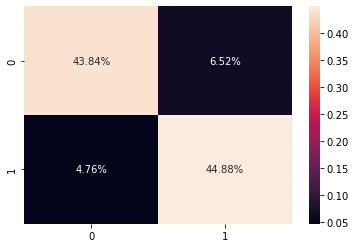

In [30]:
sns.heatmap(conf_matrix / np.sum(conf_matrix), annot=True, fmt = '0.2%')

#### 8. Get the precision, recall, and F1-score for the test set predictions

In [33]:
report = classification_report(y_test, y_pred)
print('Report: ', report, sep = '\n')

Report: 
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2518
           1       0.87      0.90      0.89      2482

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



#### 9. Create a ROC curve for the test set

In [38]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

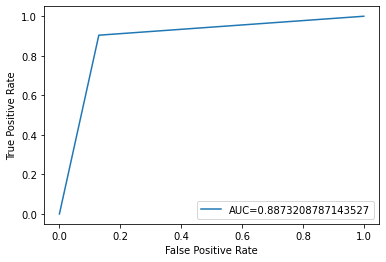

In [41]:
plt.plot(fpr, tpr, label = "AUC=" + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = "lower right")
plt.show()

The AUC indicates a good model as the curve  hugs the top left corner of the plot.

#### 10. Pick another classification model you learned about this week and repeat steps (5) - (9)

##### Naive Bayes Classifier

#### 5. Train a Naive Bayes Classifier using the training data.

In [49]:
x_train_nb = x_train.toarray()

nb_classifier_model = GaussianNB().fit(x_train_nb, y_train)
nb_train_score = nb_classifier_model.score(x_train_nb, y_train)
print(f"Train Score: {nb_train_score}")

Train Score: 0.9373


#### 6. Find the model accuracy on the test set

In [50]:
x_test_nb = x_test.toarray()

y_pred_nb = nb_classifier_model.predict(x_test_nb)
y_pred_nb

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [51]:
test_score_nb = accuracy_score(y_test, y_pred_nb)

print(f"Test Score: {test_score_nb}")

Test Score: 0.6746


#### 7. Create a confusion matrix for the test set predictions

In [52]:
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
conf_matrix_nb.shape

(2, 2)

<AxesSubplot:>

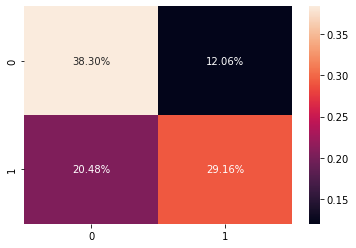

In [53]:
sns.heatmap(conf_matrix_nb / np.sum(conf_matrix_nb), annot=True, fmt = '0.2%')

#### 8. Get the precision, recall, and F1-score for the test set predictions

In [54]:
report_nb = classification_report(y_test, y_pred_nb)
print('Report: ', report_nb, sep = '\n')

Report: 
              precision    recall  f1-score   support

           0       0.65      0.76      0.70      2518
           1       0.71      0.59      0.64      2482

    accuracy                           0.67      5000
   macro avg       0.68      0.67      0.67      5000
weighted avg       0.68      0.67      0.67      5000



#### 9. Create a ROC curve for the test set

In [55]:
fpr_nb, tpr_nb, _ = metrics.roc_curve(y_test,  y_pred_nb)
auc_nb = metrics.roc_auc_score(y_test, y_pred_nb)

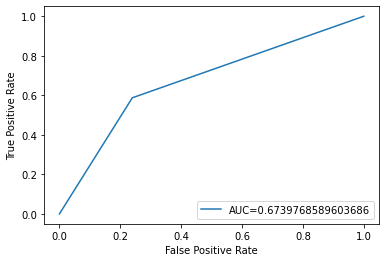

In [56]:
plt.plot(fpr_nb, tpr_nb, label = "AUC=" + str(auc_nb))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = "lower right")
plt.show()

It seems the Naive Bayes Classifier did a poorer job than the Logistic Regression model.